Instructions:


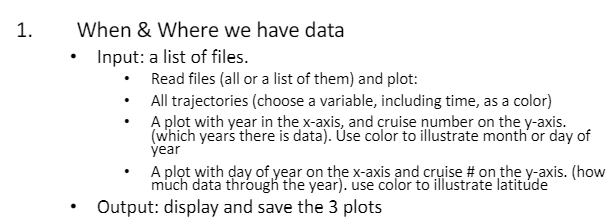

In [1]:
#import necessary packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from datetime import date
import warnings 
warnings.simplefilter('ignore') 

# Set currentYear to the current year. This is used for bounds on certain graphs 
currentYear = int(date.today().year)

# load map packages
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from calendar import month_abbr


In [8]:
# ddir = '~/Repositories/2022_SummerInternship_FarallonInstitute/saildrone_data/'  #data 2
ddir = '../../saildrone_data/'  #data 2
fn_list = ['saildrone_west_coast_survey_2018_sd1026_JPLv5.0_8dy_20210613norep_20210613_20211116.nc', 'saildrone_west_coast_survey_2019_sd1047_JPLv5.0_8dy_20210613norep_20210613_20211116.nc', 'saildrone_west_coast_survey_2019_sd1043_JPLv5.0_8dy_20210613norep_20210613_20211116.nc']

In [9]:
# classxarray.Dataset(data_vars=None, coords=None, attrs=None)

# open the first dataset
sail = xr.open_dataset(ddir+fn_list[0])
# give the first dataset a relative ID so all datasets can be differentiated
sail["relativeID"] = 0
# make lists for certain variables that remain constant for each dataset. these are used later in the last two cells
yearList = [sail["time"][0].dt.year]
durationList = [sail["time"][len(sail["time"])-1] - sail["time"][0]]
# take the actual cruise ID from the dataset attributes and put it in a new list
realID = [int(sail.attrs["id"])]
#add the duration back to the dataset
sail["duration"] = durationList[0]

 # repeat previous steps for other datasets that need to be combined.
    
if(len(fn_list)>1):
    for i in range(1, len(fn_list)):
        temp = xr.open_dataset(ddir+fn_list[i])
        temp["relativeID"] = i
        yearList.append(temp["time"][0].dt.year)
        realID.append(int(temp.attrs["id"]))
        tempDuration = temp["time"][len(temp["time"])-1] - temp["time"][0]
        temp["duration"] = tempDuration
        durationList.append(tempDuration)
        sail = xr.concat([sail, temp], dim="time")
        temp.close()
sail.head()




<xarray.Dataset>
Dimensions:                       (time: 5)
Coordinates:
    trajectory                    (time) object '1026.0' '1026.0' ... '1026.0'
  * time                          (time) datetime64[ns] 2018-07-08 ... 2018-0...
    ob                            (time) int64 0 1 2 3 4
Data variables: (12/43)
    lat                           (time) float64 37.72 37.68 37.62 37.61 37.64
    lon                           (time) float64 -122.8 -122.9 ... -123.4 -123.7
    SOG_MEAN                      (time) float64 1.87 2.226 2.05 2.004 2.139
    COG_MEAN                      (time) float64 237.8 239.4 263.5 265.3 209.5
    HDG_MEAN                      (time) float64 235.1 245.4 268.7 274.0 199.2
    PITCH_MEAN                    (time) float64 2.4 2.503 3.184 3.257 3.365
    ...                            ...
    analysed_sst                  (time) float64 287.5 287.5 287.3 287.4 287.9
    analysis_error                (time) float64 0.4 0.4 0.39 0.3805 0.3809
    mask                          (time) float64 1.0 1.0 1.0 1.0 1.0
    sea_ice_fraction              (time) float64 nan nan nan nan nan
    relativeID                    (time) int64 0 0 0 0 0
    duration                      (time) timedelta64[ns] 109 days 21:14:18.31...
Attributes: (12/47)
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_resolution:  PT1M
    time_coverage_start:       2018-07-08T00:00:00Z
    title:                     Saildrone West Coast Survey 2018
    uuid:                      3e4ce677-18db-4ba8-9c73-f2c1f3ad15ce
    Westernmost_Easting:       -125.3254656
    vehicle_id:                sd1026

['lat', 'lon', 'SOG_MEAN', 'COG_MEAN', 'HDG_MEAN', 'PITCH_MEAN', 'BARO_PRES_MEAN', 'TEMP_AIR_MEAN', 'RH_MEAN', 'PAR_AIR_MEAN', 'UWND_MEAN', 'VWND_MEAN', 'WWND_MEAN', 'GUST_WND_MEAN', 'TEMP_CTD_MEAN', 'TEMP_CTD_STDDEV', 'SAL_CTD_MEAN', 'CHLOR_MEAN', 'ROLL_MEAN', 'TEMP_RBR_MEAN', 'SAL_RBR_MEAN', 'TEMP_O2_RBR_MEAN', 'CDOM_MEAN', 'CHLOR_WETLABS_MEAN', 'WIND_MEASUREMENT_HEIGHT_MEAN', 'sat_smap_sss', 'sat_anc_sss', 'sat_anc_sst', 'sat_smap_spd', 'sat_smap_high_spd', 'sat_weight', 'sat_land_fraction', 'sat_ice_fraction', 'sat_smap_sss_uncertainty', 'sat_lat', 'sat_lon', 'dist_land', 'analysed_sst', 'analysis_error', 'mask', 'sea_ice_fraction', 'relativeID', 'duration']
what variable should be plotted:TEMP_CTD_MEAN


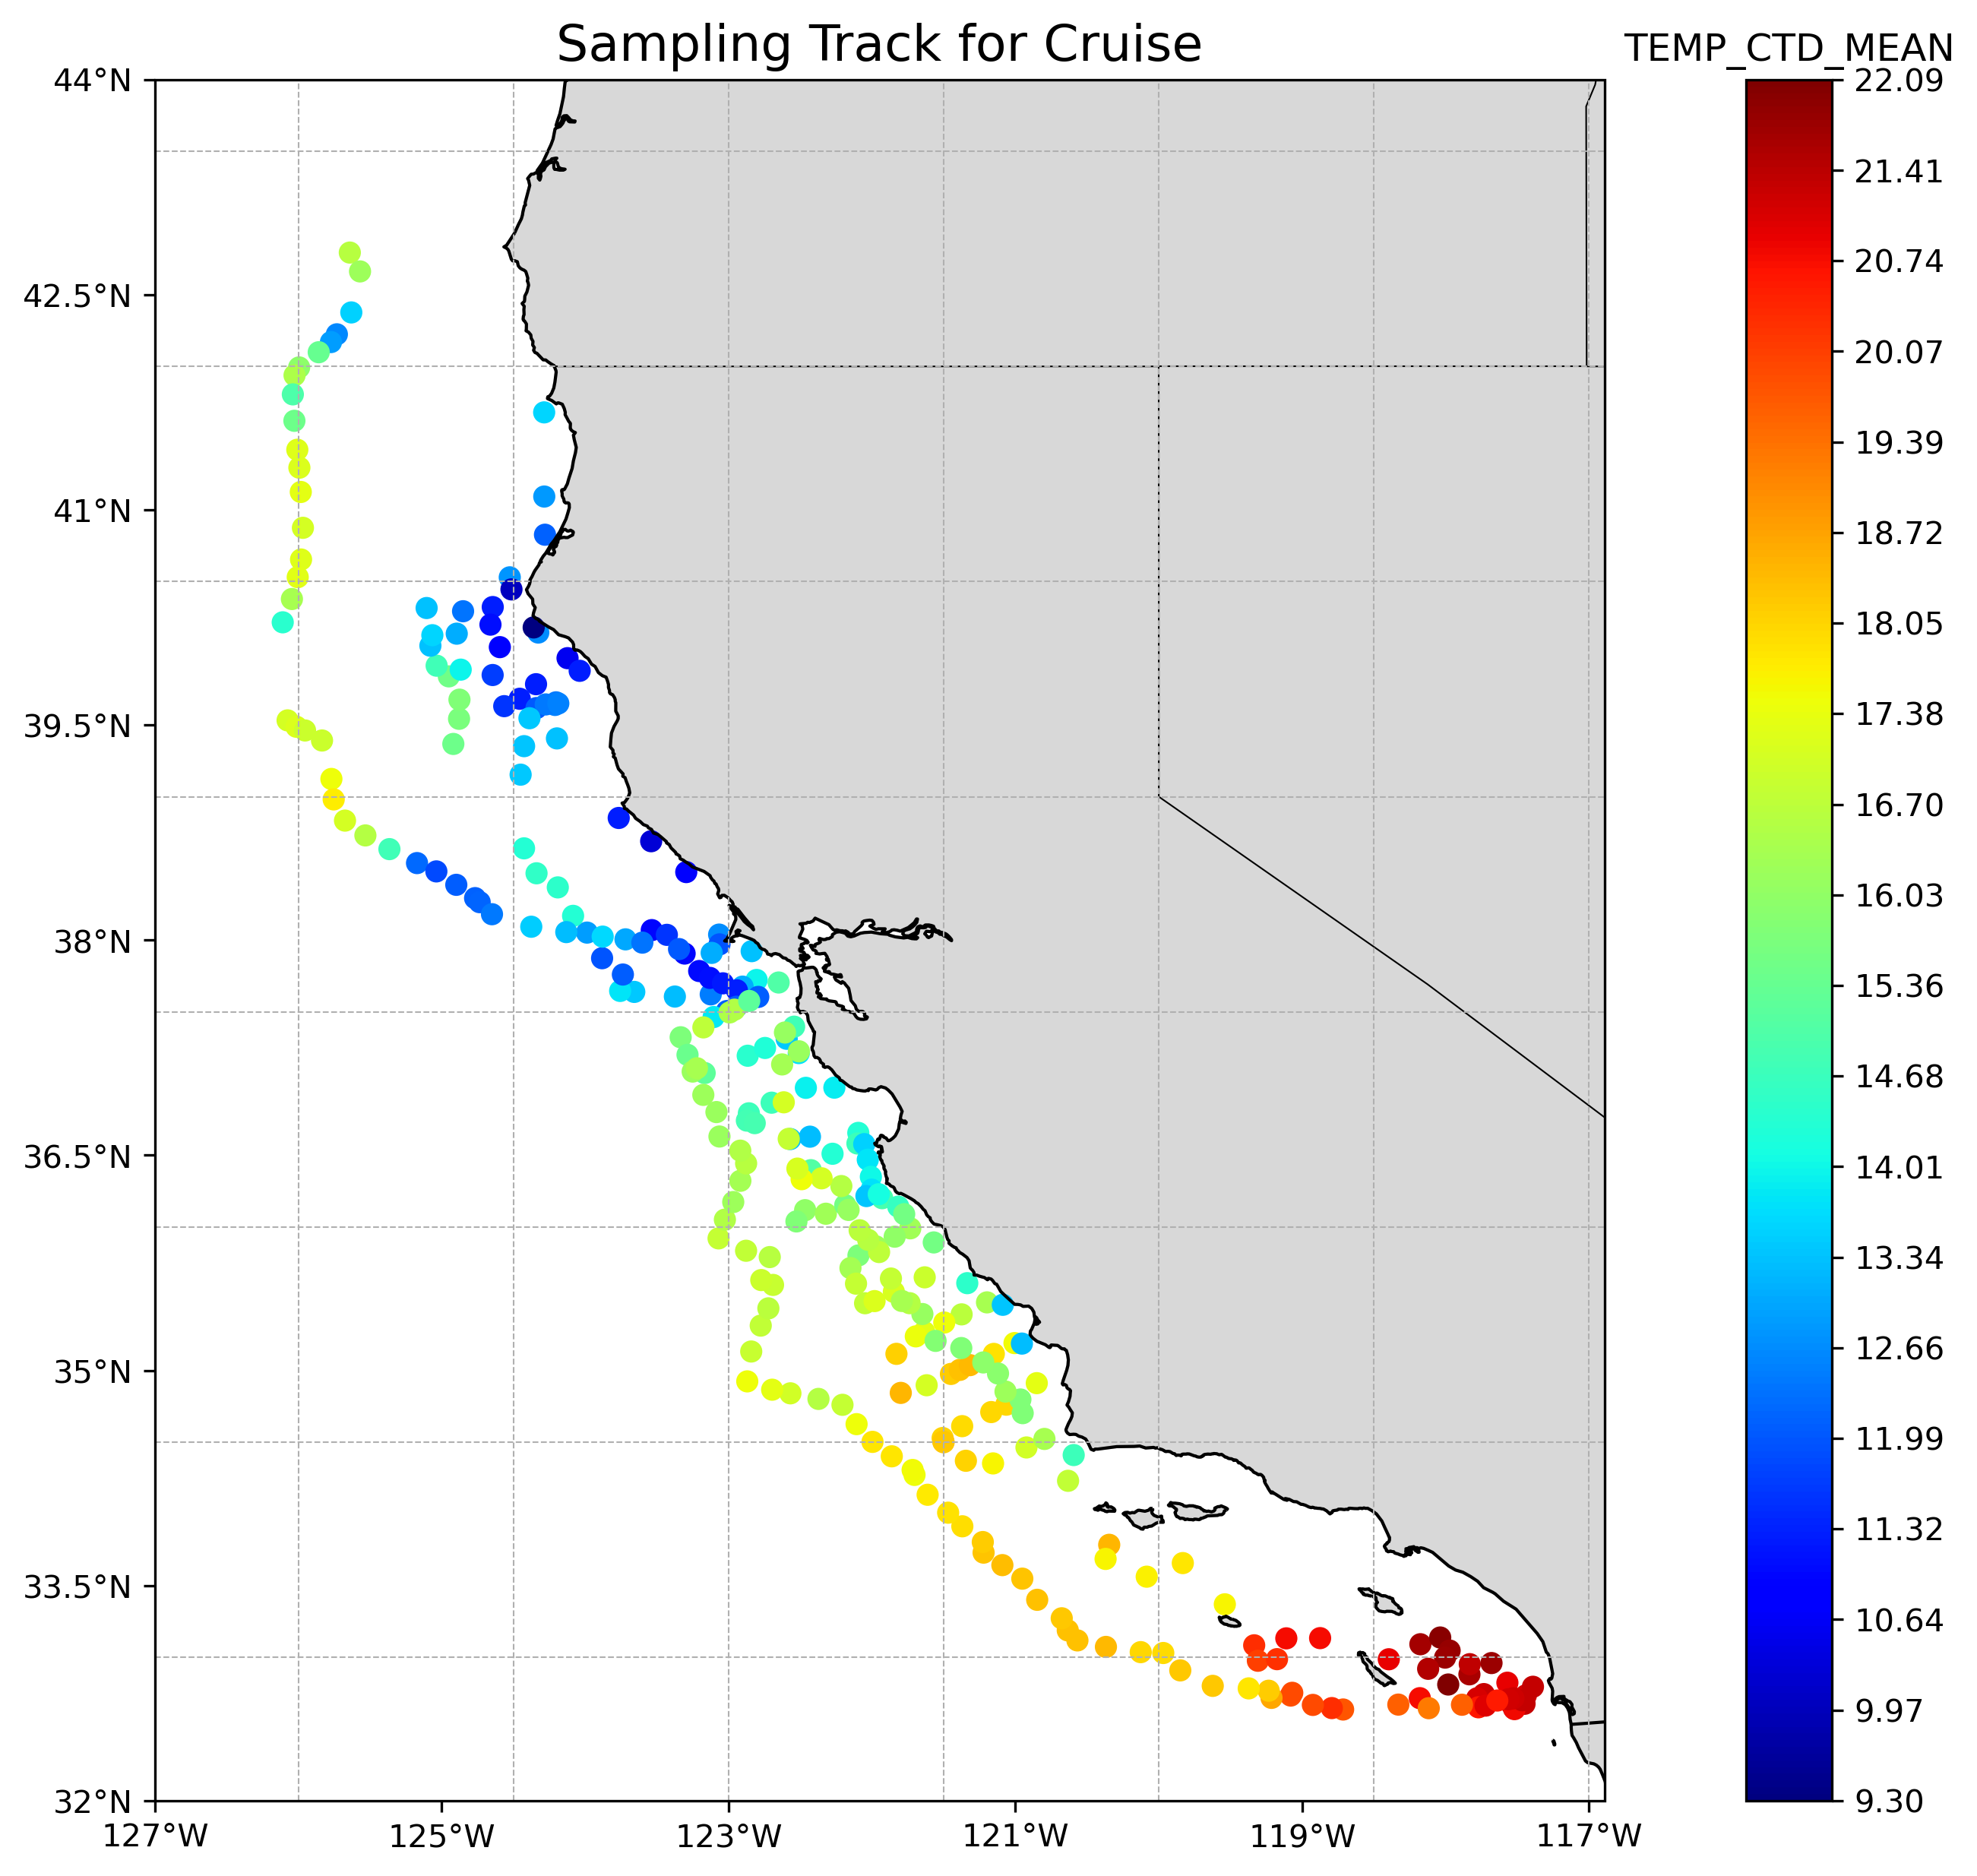

In [10]:
# reformat dates
sail['date'] = mdates.date2num(sail['time'].dt.date)

# ask what variable should be plotted
print([i for i in sail.data_vars])
var_to_plot=input('what variable should be plotted:')
# make sure that variable is in the list
if var_to_plot in sail.data_vars:


    # default_x_ticks = range(0,max(sail[var_to_plot]),divmod(max(sail[var_to_plot]), 10)[0]) #selects out 10 evenly spaced dates from the data
    #define latitude and longitude boundaries
    latr = [min(sail['lat']), max(sail['lat'])] 
    lonr = [max(sail['lon']), min(sail['lon'])] 

    # Select a region of our data, giving it a margin
    margin = 0.5 
    region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]+margin,lonr[1]-margin]]) 

    #add state outlines
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')

    # Create and set the figure context
    fig = plt.figure(figsize=(16,10), dpi = 300) 
    ax = plt.axes(projection=ccrs.PlateCarree()) 
    ax.coastlines(resolution='10m',linewidth=1,color='black') 
    ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
    ax.add_feature(states_provinces, linewidth = 0.5)
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
    ax.set_xticks(np.round([*np.arange(region[1,1],region[1,0]+1,2)][::-1],0), crs=ccrs.PlateCarree()) 
    ax.set_yticks(np.round([*np.arange(np.floor(region[0,0]),region[0,1]+1,1.5)],1), crs=ccrs.PlateCarree()) 
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(linestyle = '--', linewidth = 0.5)

    # Plot track data, color by temperature

    sc = plt.scatter(x = sail['lon'], y = sail['lat'], c = sail[var_to_plot], cmap='jet')

    # make the colorbar with 20 evenly spaced labels
    clb = fig.colorbar(sc, ticks=np.linspace(min(sail[var_to_plot]), max(sail[var_to_plot]), 20))
    clb.ax.set_title(var_to_plot)


    # title the graph
    plt.title('Sampling Track for Cruise', fontdict = {'fontsize' : 16})
    
    # remove slashes from variable name to make sure it it saved correctly
    sanitized_var_to_plot = var_to_plot.replace("/","")
    
    # save file
    plt.savefig('Saved Graphs/Sampling Track of ' + sanitized_var_to_plot + '.png') 
    
    # show and clear the plt object
    plt.show()
    
else:  # if the variable the user wants to plot is not in the dataset, give an error
    raise Exception("variable must be in the list")

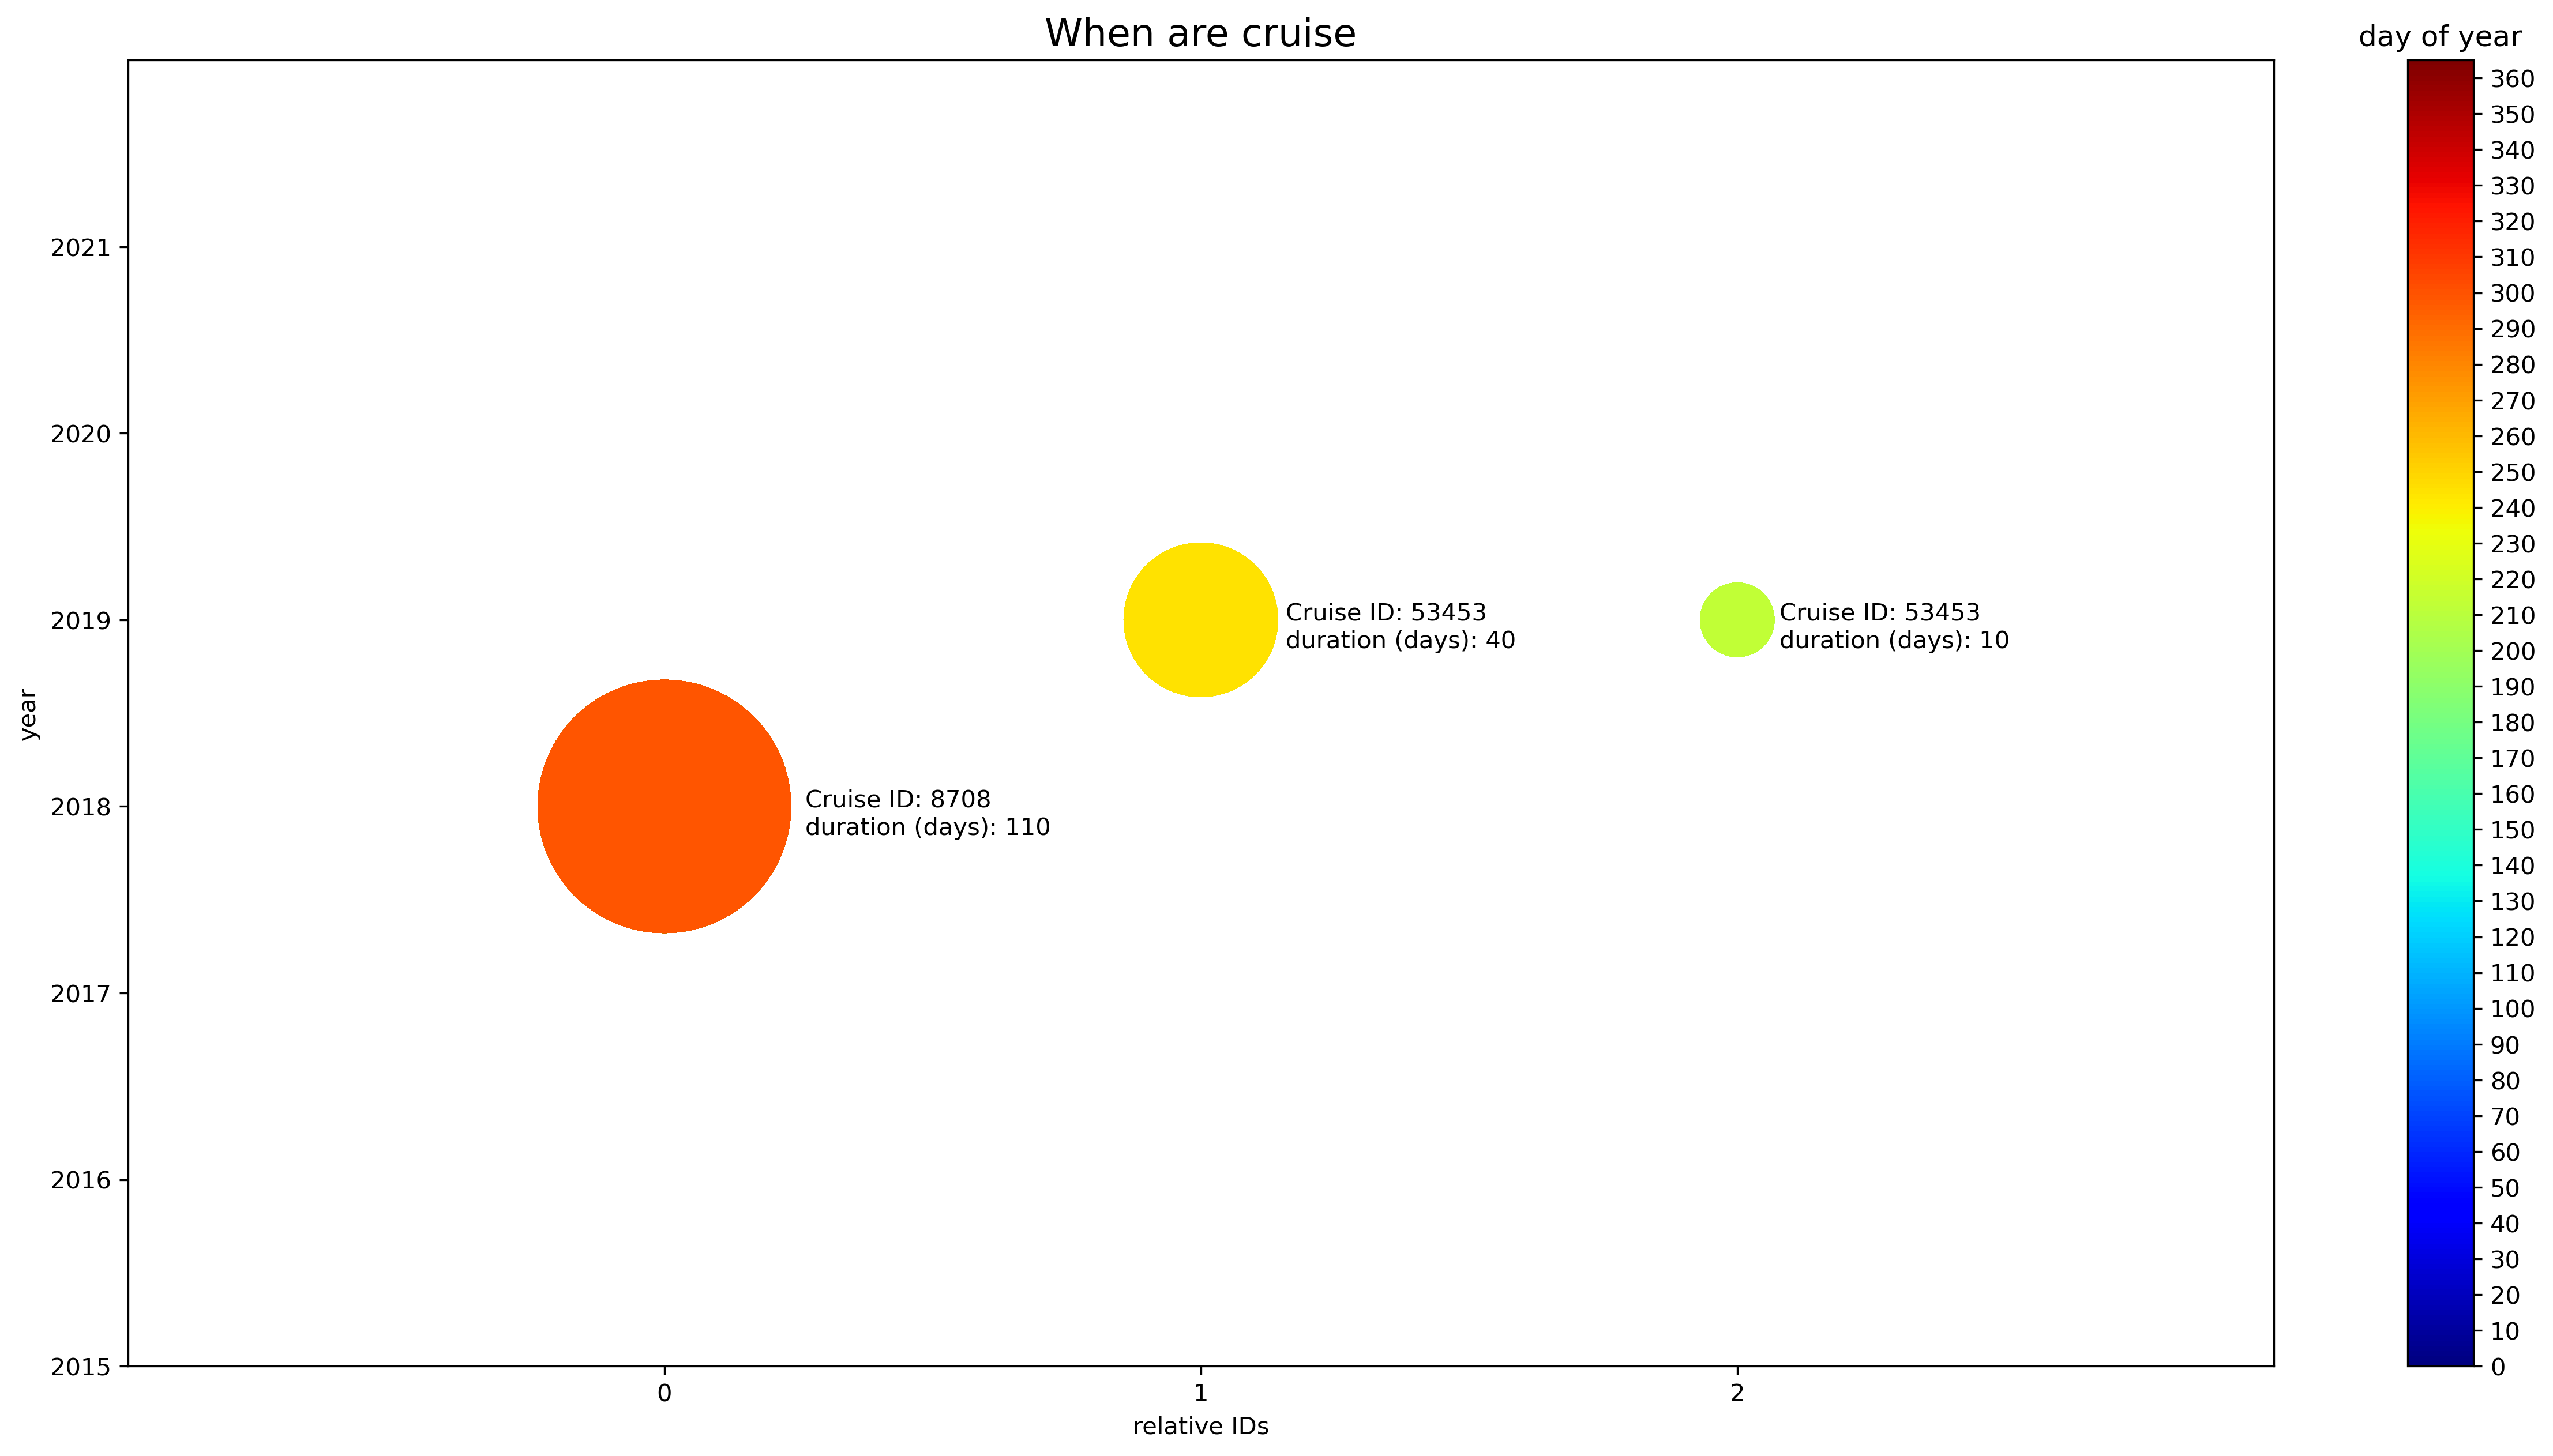

In [11]:
# initialize variables and objects
fig = plt.figure(figsize=(20,10), dpi = 300) 
ax = plt.axes()
# plot the data
pl_obj = plt.scatter(x =sail["relativeID"] , y =sail['time'].dt.year, s=(sail['duration'].dt.days)*100, c = sail['time'].dt.dayofyear, cmap='jet', vmin = 0, vmax = 365) # 
# Add the colorbar
clb = fig.colorbar(pl_obj, ticks=range(0,365,10))
clb.ax.set_title("day of year")
# Label and add tick marks to the axes 
ax.set(xlim=(-1, max(sail["relativeID"])+1), xticks=np.arange(-1, max(sail["relativeID"]))+1,
    ylim=(2015, currentYear), yticks=np.arange(2015, currentYear))
ax.set_ylabel("year")
ax.set_xlabel("relative IDs")

# annotate points with more information
# Because the Cruise IDs are so arbitrary and spread out, they can't be plotted without the graph looking weird

annotate = True
if(annotate):
    # for each original dataset
    for i in range(len(realID)):
        # get the duration in days. (durationList stores nanoseconds)
        duration = float(durationList[i])/86400000000000
        # calculate the offset the text should be from the center of the point. Purely visual calculation.
        xOffset = np.sqrt(duration)/40
        # annotate the cruise ID
        plt.annotate(("Cruise ID: " + str(realID[i]))
                     , (i+xOffset, yearList[i]))
        # annotate the duration
        plt.annotate(("duration (days): " + str(round(duration)))
                     , (i+xOffset, yearList[i]-0.15))

# title the graph
plt.title('When are cruise', fontdict = {'fontsize' : 16})
# save the plot as a png
plt.savefig('Saved Graphs/When are cruise.png')
# show and clear the plt object
plt.show()

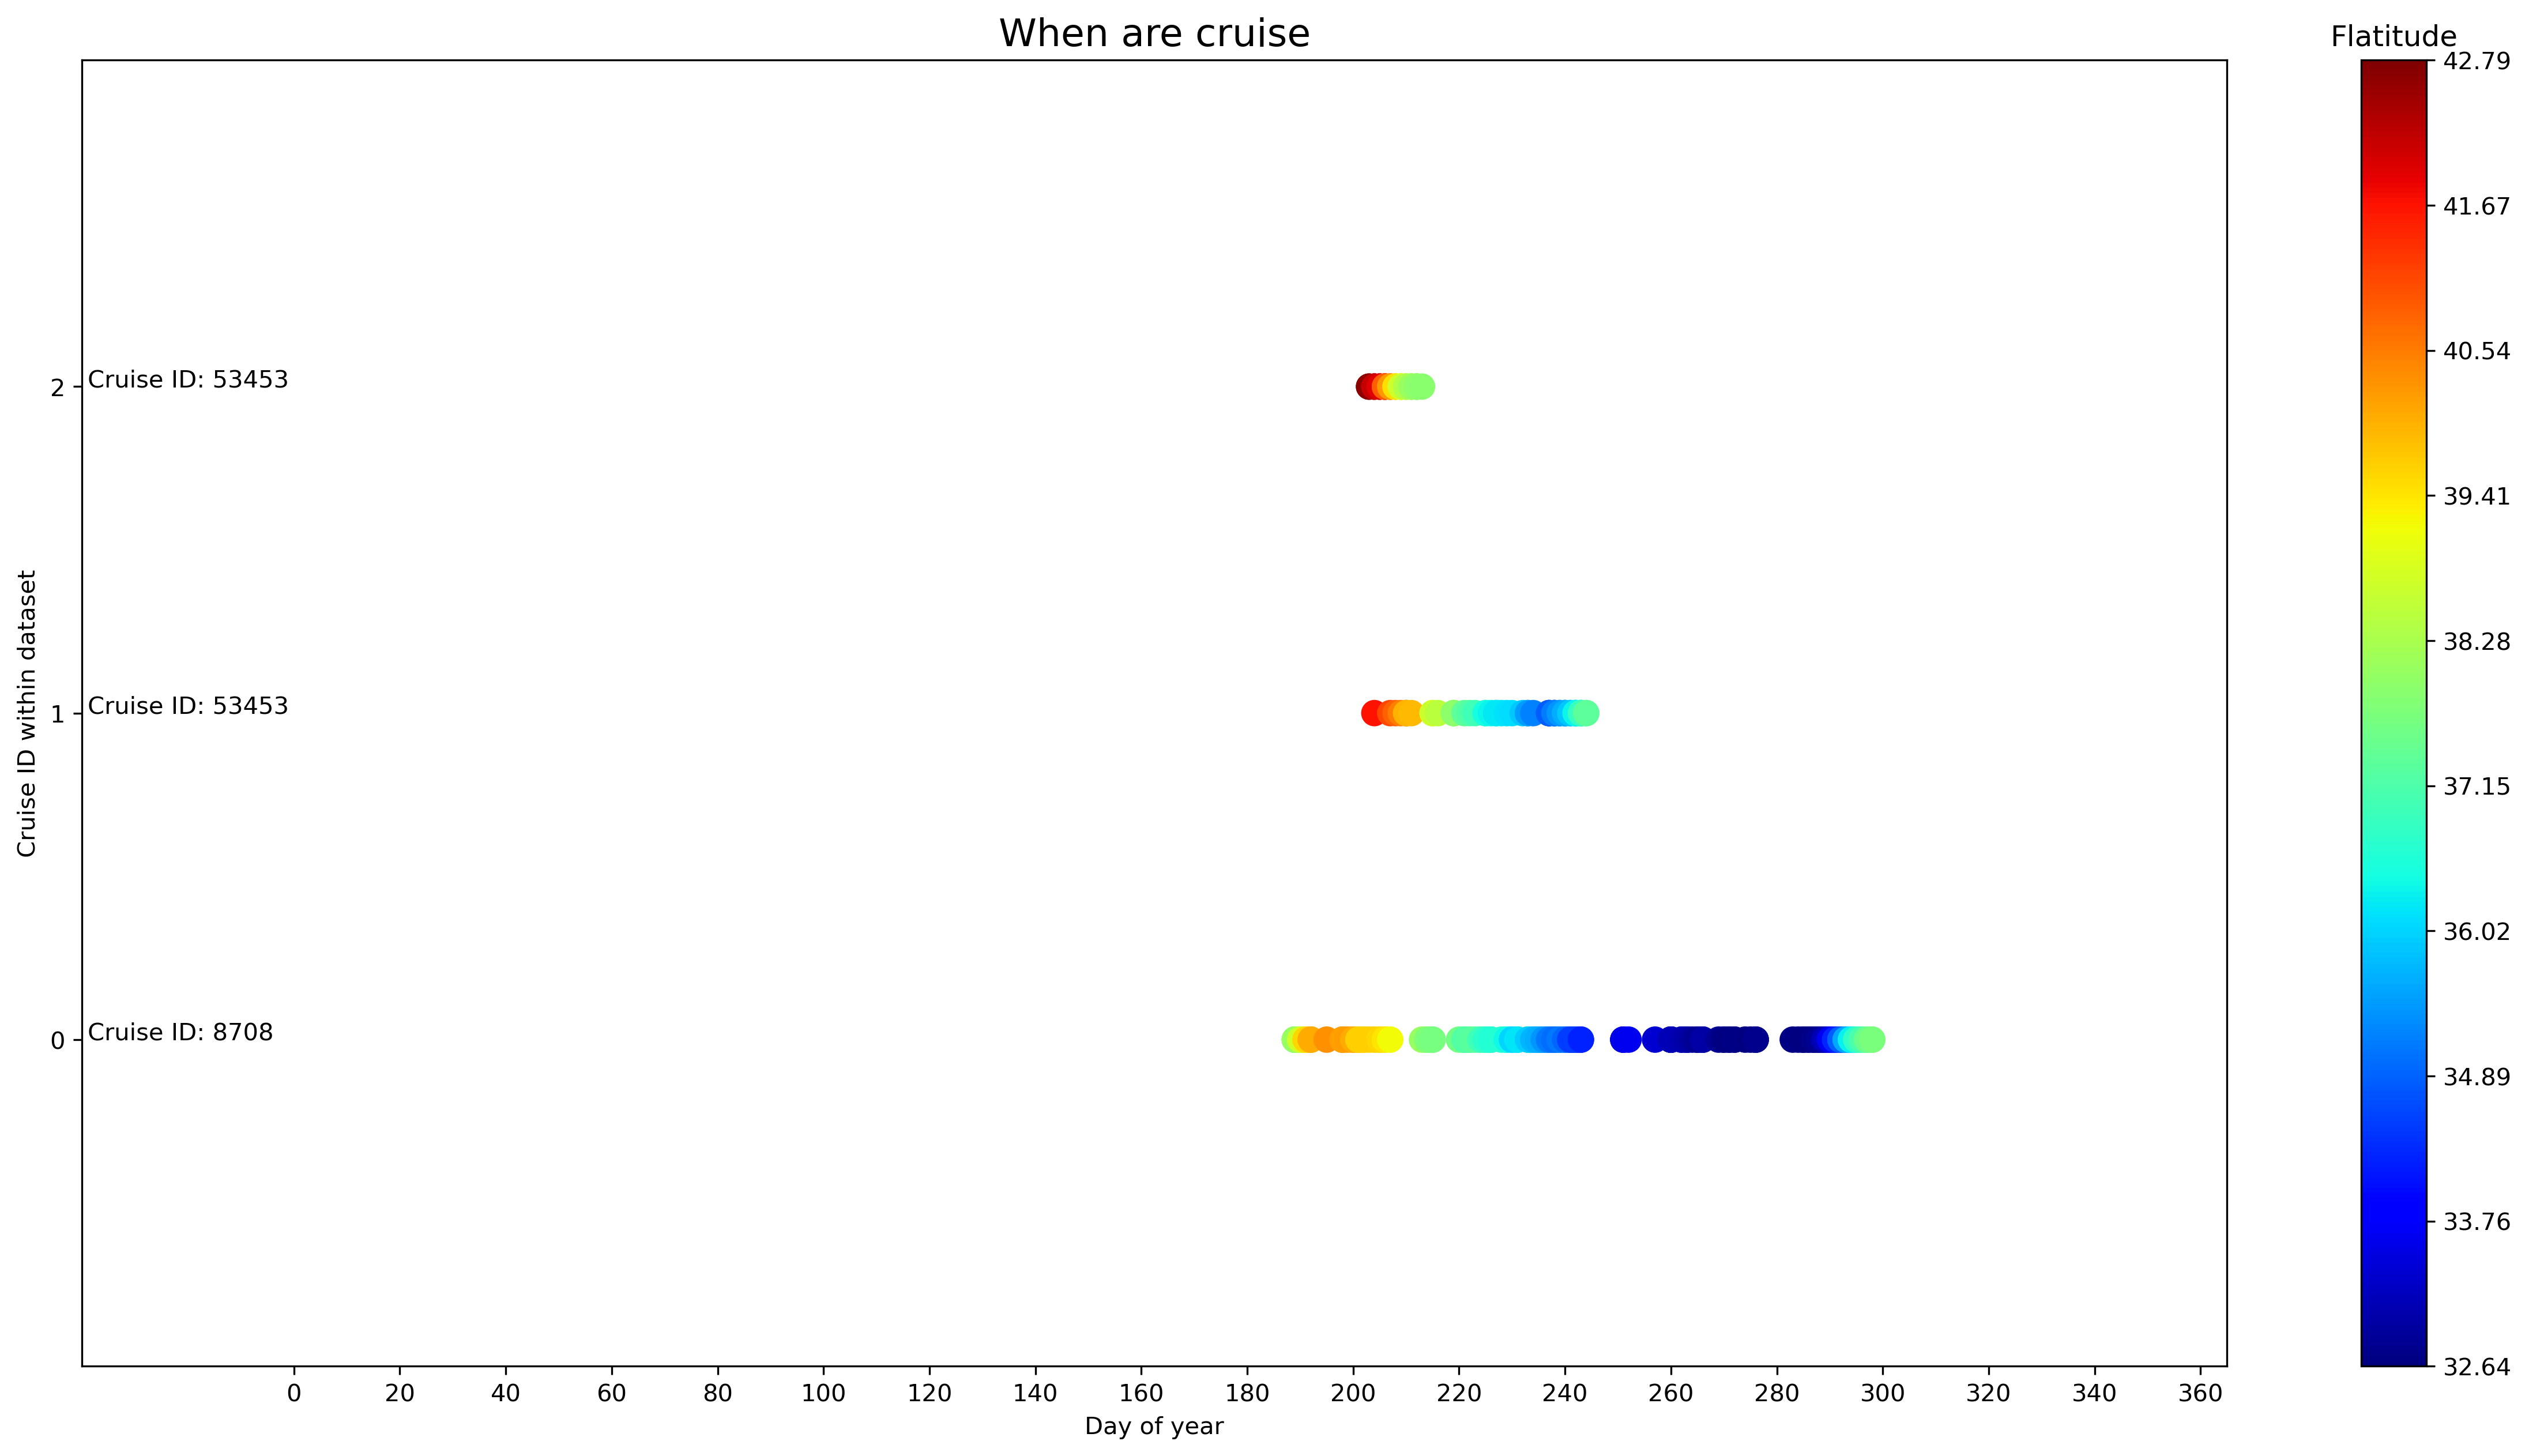

In [12]:
# initialize variables and objects
fig = plt.figure(figsize=(20,10), dpi = 300) 
ax = plt.axes()
# plot the data
pl_obj = plt.scatter(x =sail['time'].dt.dayofyear , y =sail["relativeID"], s = 100, c = sail['lat'], cmap='jet')
# Add the colorbar
clb = fig.colorbar(pl_obj, ticks=np.linspace(min(sail['lat']),max(sail['lat']),10))
clb.ax.set_title("Flatitude")
# Label and add tick marks to the axes 
ax.set(xlim=(-40, 365), xticks=range(0,365,20),
    ylim=(-1, max(sail["relativeID"])+1), yticks = np.arange(0, max(sail["relativeID"])+1))
ax.set_ylabel("Cruise ID within dataset")
ax.set_xlabel("Day of year")

# add real cruise IDs to the left of the graph
for i in range(len(realID)):
    
    duration = float(durationList[i])/86400000000000
    
    xOffset = np.sqrt(duration)/40
    
    plt.annotate(("Cruise ID: " + str(realID[i]))
                 , (-39, i))


# title the graph
plt.title('When are cruise', fontdict = {'fontsize' : 16})
# save the plot as a png
plt.savefig('Saved Graphs/When are cruise - part 2 electric bugaloo.png')
# show and clear the plt object
plt.show()